# Singapore HDB Price Analysis (2024) (Using SQL)

In [212]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [213]:
df = pd.read_csv('HDB_faltData.csv')
df['month'] = pd.to_datetime(df['month'])
df.rename(columns={
    'month': 'date'
}, inplace=True)
df = df[(df['date'] >= '2024-01-01') & (df['date'] < '2025-01-01')]

In [214]:
conn = sqlite3.connect('flatData.db')
df.to_sql('flat_data', conn, if_exists='replace', index=False)

27852

In [215]:
query = 'select * from flat_data limit 5'
pd.read_sql(query, conn)

,date,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2024-02-01 00:00:00,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,01 TO 03,44.0,Improved,1979,54 years 04 months,285000.0
1,2024-12-01 00:00:00,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,04 TO 06,44.0,Improved,1979,53 years 07 months,320000.0
2,2024-02-01 00:00:00,ANG MO KIO,2 ROOM,323,ANG MO KIO AVE 3,04 TO 06,44.0,Improved,1977,52 years 05 months,293000.0
3,2024-02-01 00:00:00,ANG MO KIO,2 ROOM,314,ANG MO KIO AVE 3,01 TO 03,44.0,Improved,1978,52 years 11 months,303000.0
4,2024-04-01 00:00:00,ANG MO KIO,2 ROOM,314,ANG MO KIO AVE 3,01 TO 03,44.0,Improved,1978,52 years 10 months,288000.0


## Q1: Which top 5 town has the highest average resale price?

In [216]:
query = 'select town, round(avg(resale_price),2) as avg_resale_price from flat_data group by town order by avg_resale_price desc limit 5'
pd.read_sql(query, conn)

,town,avg_resale_price
0,BUKIT TIMAH,883392.77
1,BISHAN,830693.71
2,CENTRAL AREA,757515.75
3,BUKIT MERAH,724272.81
4,PASIR RIS,703587.85


Highest average resale price: **BUKIT TIMAH** (SGD 883k) 

## Q2: How do resale prices trend over time?

In [217]:
query = 'select strftime("%m", date) as month, round(avg(resale_price),2) as avg_flat_price from flat_data group by strftime("%m", date)'
trend = pd.read_sql(query, conn)

In [218]:
price_Jan = trend.iloc[0]['avg_flat_price']
price_Dec = trend.iloc[-2]['avg_flat_price']
price_increase_percent = round(((price_Dec - price_Jan) / price_Jan) * 100)
print(f'The price incresed by {price_increase_percent}%.')

The price incresed by 7%.


Prices increased by **7% YoY** from JAN to DEC during 2024.  

## Q3: Which flat type is most expensive?

In [219]:
query = 'select flat_type, round(avg(resale_price),2) as avg_flat_price from flat_data group by flat_type order by avg_flat_price desc'
pd.read_sql(query, conn)

,flat_type,avg_flat_price
0,MULTI-GENERATION,1049000.00
1,EXECUTIVE,874650.59
2,5 ROOM,728615.22
3,4 ROOM,627382.84
4,3 ROOM,439910.47
5,2 ROOM,340847.70
6,1 ROOM,253363.64


Most expensive flat type: **MULTI-GENERATION** (avg. SGD 1049k).

## Q4: Which towns have average resale prices higher than the national average?

In [220]:
query = '''
        select town, avg(resale_price) as avg_resale_price 
        from flat_data 
        group by town 
        having avg_resale_price > 
            (
                select avg(resale_price) from flat_data
            ) 
        order by avg_resale_price desc
        '''
        
query2 = 'select avg(resale_price) as avg_price from flat_data'
result = pd.read_sql(query, conn)
result2 = pd.read_sql(query2, conn)

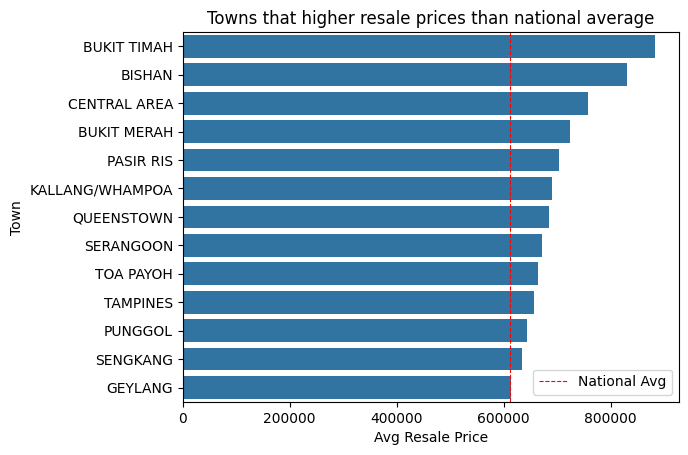

In [221]:
sns.barplot(data=result, y='town', x='avg_resale_price')
plt.axvline(x=result2['avg_price'][0], color='red', linestyle='--', linewidth=0.8, label='National Avg')
plt.title('Towns that higher resale prices than national average')
plt.xlabel('Avg Resale Price')
plt.ylabel('Town')
plt.legend()
plt.show()

## Q5: Find flats where the price is 20% higher than the average price in their town.

In [222]:
query = '''
        select flat_type, d1.town, d1.resale_price 
        from 
                (
                        select flat_type, town, resale_price 
                        from flat_data 
                        group by flat_type, town
                ) as d1
                join 
                (
                        select town, avg(resale_price) as avg_price
                        from flat_data 
                        group by town
                ) as d2
                using (town)
        where resale_price > (120*avg_price)/100
        order by resale_price desc
        limit 5
        '''
pd.read_sql(query, conn)

,flat_type,town,resale_price
0,5 ROOM,CENTRAL AREA,1450000.0
1,EXECUTIVE,BISHAN,1380000.0
2,EXECUTIVE,BUKIT TIMAH,1360000.0
3,EXECUTIVE,ANG MO KIO,1238888.0
4,EXECUTIVE,QUEENSTOWN,1228000.0


## Q6: Compare each month’s average price to the previous month using subqueries.

In [223]:
query = '''
        SELECT
            strftime("%Y-%m", h1.month) AS month,
            round(h1.avg_price,2) as curr_month_avg,
            (
                SELECT round(AVG(resale_price),2)
                FROM flat_data
                WHERE strftime("%Y-%m", date) = strftime("%Y-%m", date(h1.month, '-1 month'))
            ) AS prev_month_avg
        FROM (
            SELECT
                date AS month,
                AVG(resale_price) AS avg_price
            FROM flat_data
            GROUP BY strftime("%Y-%m", date)
        ) h1;
        '''

result = pd.read_sql(query, conn)

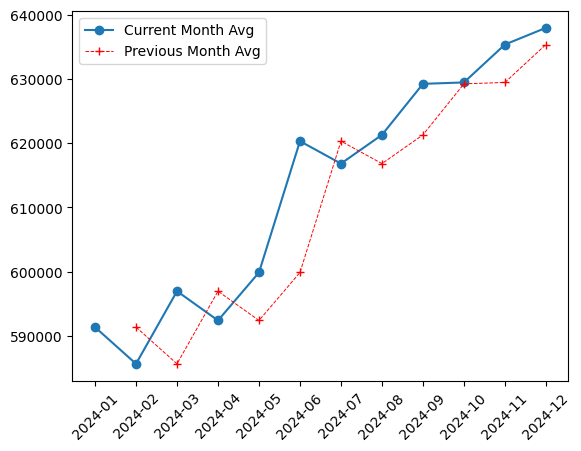

In [224]:
plt.plot(result['month'], result['curr_month_avg'], marker='o', label='Current Month Avg')
plt.plot(result['month'], result['prev_month_avg'], marker='+', linestyle='--', color='red', linewidth=0.7, label='Previous Month Avg')
plt.xticks(rotation=45)
plt.legend()
plt.show()

## Q7: Calculate the 6-month rolling average price for each town.

In [270]:
query = '''
    with temp_table as (
        select town, strftime("%m", date) as month, AVG(resale_price) as avg_price
        from flat_data 
        group by town, month
        order by avg_price
    ) 
    select town, month,
        avg(avg_price) over 
            (partition by town 
            order by month
            rows between 5 preceding and current row) 
            six_month_rolling_avg_price 
    from temp_table 
    where town = "YISHUN"	
'''
result = pd.read_sql(query, conn)

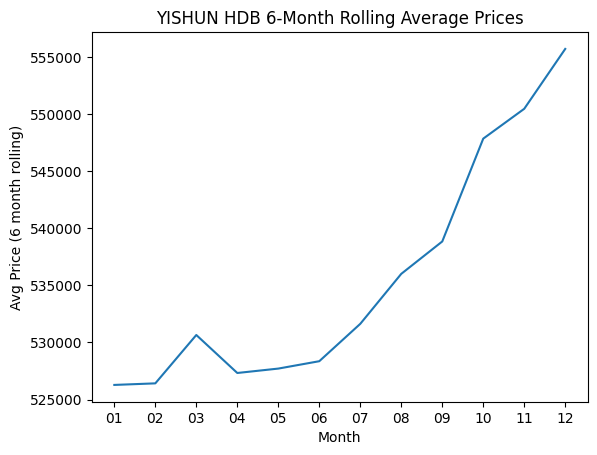

In [271]:
plt.plot(result['month'], result['six_month_rolling_avg_price'])
plt.title("YISHUN HDB 6-Month Rolling Average Prices")  
plt.xlabel('Month')
plt.ylabel('Avg Price (6 month rolling)')
plt.show()